<a href="https://colab.research.google.com/github/dqniellew1/DLPT/blob/master/Using_convolutions_to_generalize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
drive_dir = 'drive/My Drive/dlwpt-code/data/'

Taking a 1D view of our input image and multiplying it with a `n_output_features x n_input_features` weight matrix, as done in `nn.Linear`, means taking all pixels in the image, and for each channel computing a weighted sum of all pixels multiplied by a set of weights, one per output feature.

In [7]:
%matplotlib inline 
from matplotlib import pyplot as plt
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

In [8]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [9]:
from torchvision import datasets, transforms

data_path = '../data-unversioned/p1ch6/'
cifar10 = datasets.CIFAR10(data_path, train=True, download=True,
                           transform=transforms.Compose([
                                                         transforms.ToTensor(),
                                                         transforms.Normalize(
                                                             (0.4915, 0.4823, 0.4468),
                                                             (0.2470, 0.2435, 0.2616))
                                                         ]))

Extracting ../data-unversioned/p1ch6/cifar-10-python.tar.gz to ../data-unversioned/p1ch6/


In [10]:
cifar10_val = datasets.CIFAR10(data_path, train=False, download=False,
                               transform=transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Normalize((0.4915, 0.4823, 0.4468),
                                                   (0.2470, 0.2435, 0.2616))
                              ]))

In [11]:
label_map = {0:1, 2:1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label]) for img, label in cifar10 if label in [0, 2]]
cifar2_val = [(img, label_map[label]) for img, label in cifar10_val if label in [0, 2]]

# Convolutions

`nn.Conv1d` for time series, `nn.Conv2d` for images and `nn.Conv3d` for volumes or videos.

The arguments we provide to `nn.Conv2d` are the:
1. The number of input features (or channels, since we are dealing with so-called multi-channel images, i.e. more than one value per pixel)
2. The number of output features (arbitrary number, the more channels in the output image, the more the capacity of the network)
3. The size of the kernel


In [4]:
conv = nn.Conv2d(3, 16, kernel_size=3)
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

We expect the weight tensor to be sized `n_input_channels x 3 x 3 x n_output_channels`. The bias is just a constant value we add to each channel of the output image.

\* weights are initialized randomly

**As usual we need to add the zero-th batch dimension with unsqueeze** if we want to call the `conv` module with one input image. `nn.Conv2d` expects `B x C x H x W`.

In [6]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

In [13]:
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

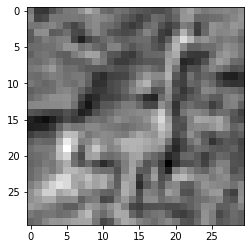

In [16]:
plt.imshow(output[0,0].detach(), cmap='gray')
plt.show()
# Bird after a random convolution treatment

The output size is slightly less because it is a side effect of deciding what to do at the boundary of the image.

To preserve image size, PyTorch gives us the possibility of padding the image, creating ghost pixels around the border that value zero as far as the convolution is concerned.

Specifying `padding=1` when `kernel_size=3` means that now `i00` has an extra set of neighbours above and left, so that an output of the convolution can be computed even in the corner of our original image.

In [19]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

\* the size of `weight` and `bias` dont change whether padding is used or not.

In [22]:
# play with convolution setting; weights by hand
with torch.no_grad():
  conv.bias.zero_() # zero out bias to remove any confounding factor

with torch.no_grad():
  conv.weight.fill_(1.0 / 9.0)

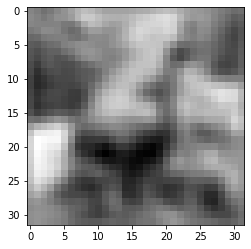

In [23]:
# See the results in the output image
output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()
# bird, this time blurred thanks to a constant convolution kernel.

Every pixel of the output is the average of a neighborhood of the input, so output pixels of the output will be correlated and change more smoothly.

In [24]:
# We can try something different
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)

with torch.no_grad():
  conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0]])
  conv.bias.zero_()

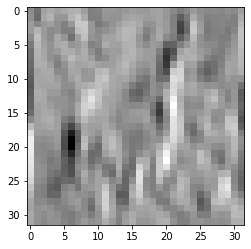

In [25]:
output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()
# Vertical edges throughout our bird because of hand-crafted kernel

## Depth and pooling

If we wish to downsample our image by half, we'll want to use a size of 2.

In [27]:
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))

img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

Proceed to building our convolutional neural network for detecting birds and planes.

In [28]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    nn.Conv2d(16, 8, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
)

Gone from 3 RGB channels to 16, thereby giving the network a chance to generate 16 independent features that will operate to hopefully discriminate low-level features of birds and airplanes. 

After the activation is applied, the 16-channel 32x32 image will be pooled to a 16-channel 16x16 image. 

At this point, the downsampled image will undergo another convolution that will generate a 8-channel 16x16 output, which again after the activation, will be pooled to a 8-channel 8x8 output.

After the input image has been reduced to a set of 8x8 features, we expect some output of probabilities, so that we can feed our negative log likelihood. 

However, probabilities are a pair of numbers in a 1D vector (1 for bird, 1 for airplane, while we are still dealing with multi-channel 2D features.

In [29]:
# Turn our 8-channel 8x8 image into a 1D vector 
# Complete our network with a set of fully connected layers.
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    nn.Conv2d(16, 8, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    # ... Missing something important?
    nn.Linear(8 * 8 * 8, 32),
    nn.Tanh(),
    nn.Linear(32, 2))
# Linear layer is dependent on the expected size of the MaxPool2d output
# i.e. 8 * 8 * 8 = 512

In [30]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

Reasonable! In order to increase the capacity of the model, we could
1. increase the number of output channels for the conv layers (which would lead to the linear layer increasing in size as well)

In [31]:
model(img.unsqueeze(0))

RuntimeError: ignored

What is missing there is the **reshaping step** from a 8-channel 8x8 image to a 512-element, 1D vector.

We could use `view` on the output of the last `nn.MaxPool2d` but we dont have visibility of output of each module when we use `nn.Sequential`.